In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

In [107]:
train = pd.read_csv('taxitrain1.csv',nrows=100000,parse_dates = ['pickup_datetime'])

In [109]:
train.info()
#contains no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
key                  100000 non-null object
fare_amount          100000 non-null float64
pickup_datetime      100000 non-null datetime64[ns]
pickup_longitude     100000 non-null float64
pickup_latitude      100000 non-null float64
dropoff_longitude    100000 non-null float64
dropoff_latitude     100000 non-null float64
passenger_count      100000 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


In [110]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


In [111]:
#New york lies in latitude 40.7 and the lontitude is -74. Some records have latitude in range of 401/404 which is not possible
# We shall remove those records (outliers)

In [112]:
train = train.drop(train[(train['pickup_latitude'] < 37) | (train['pickup_latitude'] > 42)].index)

In [113]:
train = train.drop(train[(train['dropoff_latitude'] < 37) | (train['dropoff_latitude'] > 42)].index)

In [114]:
train = train.drop(train[(train['dropoff_longitude'] > -70) | (train['dropoff_longitude'] < -75)].index)
train = train.drop(train[(train['pickup_longitude'] > -70) | (train['pickup_longitude'] < -75)].index)

In [115]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97910.000000,97910.000000,97910.000000,97910.000000,97910.000000,97910.000000
mean,11.342825,-73.975056,40.750974,-73.974000,40.751436,1.674252
std,9.688837,0.041904,0.034203,0.039204,0.035692,1.300166
min,-44.900000,-74.945938,38.754215,-74.945938,39.296307,0.000000
25%,6.000000,-73.992265,40.736638,-73.991399,40.735751,1.000000
50%,8.500000,-73.982076,40.753533,-73.980437,40.753961,1.000000
75%,12.500000,-73.968288,40.767677,-73.965117,40.768485,2.000000
max,200.000000,-70.140793,41.692428,-72.854940,41.714633,6.000000


In [116]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97910 entries, 0 to 99999
Data columns (total 8 columns):
key                  97910 non-null object
fare_amount          97910 non-null float64
pickup_datetime      97910 non-null datetime64[ns]
pickup_longitude     97910 non-null float64
pickup_latitude      97910 non-null float64
dropoff_longitude    97910 non-null float64
dropoff_latitude     97910 non-null float64
passenger_count      97910 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 6.7+ MB


In [117]:
#drop rows with passenger count = 0
train = train.drop(train[train['passenger_count'] == 0].index)

In [118]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97552 entries, 0 to 99999
Data columns (total 8 columns):
key                  97552 non-null object
fare_amount          97552 non-null float64
pickup_datetime      97552 non-null datetime64[ns]
pickup_longitude     97552 non-null float64
pickup_latitude      97552 non-null float64
dropoff_longitude    97552 non-null float64
dropoff_latitude     97552 non-null float64
passenger_count      97552 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 6.7+ MB


In [119]:
#drop rows with negative or 0 fare amount

In [120]:
#Minimum fare is $2.5. Assuming there was not waiting and then cancellation
train = train.drop(train[train['fare_amount'] < 2.5].index)

In [121]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97539 entries, 0 to 99999
Data columns (total 8 columns):
key                  97539 non-null object
fare_amount          97539 non-null float64
pickup_datetime      97539 non-null datetime64[ns]
pickup_longitude     97539 non-null float64
pickup_latitude      97539 non-null float64
dropoff_longitude    97539 non-null float64
dropoff_latitude     97539 non-null float64
passenger_count      97539 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 6.7+ MB


In [122]:
print(train[train['fare_amount'] > 150])

                                 key  fare_amount     pickup_datetime  \
1335     2013-01-16 20:19:58.0000001       180.00 2013-01-16 20:19:58   
1483     2009-08-07 21:49:13.0000003       165.00 2009-08-07 21:49:13   
28373  2012-02-26 03:24:00.000000155       200.00 2012-02-26 03:24:00   
43956    2014-11-01 03:35:37.0000002       165.00 2014-11-01 03:35:37   
46198  2013-05-13 11:18:00.000000139       160.00 2013-05-13 11:18:00   
61163    2015-03-03 16:34:57.0000001       160.77 2015-03-03 16:34:57   
62648    2013-04-12 03:16:58.0000001       160.00 2013-04-12 03:16:58   

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
1335         -74.429332        40.500046         -74.429332         40.500046   
1483         -73.633363        41.032490         -73.633671         41.032598   
28373        -73.954922        41.391042         -73.954918         41.391042   
43956        -73.931776        40.754153         -73.919801         40.797735   
46198     

In [123]:
#Calculate distance between pickup and drop based on latitude and longitude
#Haversine formula
#taken from stackoverflow.com
#import math
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = 6367 * c
    return km

train['distance'] = haversine(train['pickup_longitude'],train['pickup_latitude'],train['dropoff_longitude'],train['dropoff_latitude'])


In [124]:
print(train[train['fare_amount'] > 150])

                                 key  fare_amount     pickup_datetime  \
1335     2013-01-16 20:19:58.0000001       180.00 2013-01-16 20:19:58   
1483     2009-08-07 21:49:13.0000003       165.00 2009-08-07 21:49:13   
28373  2012-02-26 03:24:00.000000155       200.00 2012-02-26 03:24:00   
43956    2014-11-01 03:35:37.0000002       165.00 2014-11-01 03:35:37   
46198  2013-05-13 11:18:00.000000139       160.00 2013-05-13 11:18:00   
61163    2015-03-03 16:34:57.0000001       160.77 2015-03-03 16:34:57   
62648    2013-04-12 03:16:58.0000001       160.00 2013-04-12 03:16:58   

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
1335         -74.429332        40.500046         -74.429332         40.500046   
1483         -73.633363        41.032490         -73.633671         41.032598   
28373        -73.954922        41.391042         -73.954918         41.391042   
43956        -73.931776        40.754153         -73.919801         40.797735   
46198     

In [125]:
train['pickup_latitude'] = round(train['pickup_latitude'],4)

In [126]:
train['pickup_longitude'] = round(train['pickup_longitude'],4)
train['dropoff_latitude'] = round(train['dropoff_latitude'],4)
train['dropoff_longitude'] = round(train['dropoff_longitude'],4)

In [127]:
#drop rows that have distance less than a km
train = train.drop(train[train['distance'] < 1].index)

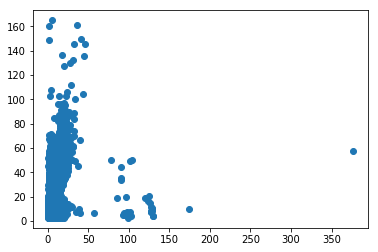

In [128]:
x = train['distance']
y = train['fare_amount']
plt.scatter(x,y)
plt.show()

In [129]:
#import datetime
#for i in range(len(train)):
#    train['tstamp'][i] = datetime.datetime.strptime(train['pickup_datetime'][i],"%d %b %Y  %H:%M:%S.%f")


train['year'] = train.pickup_datetime.dt.year
train['day'] =  train.pickup_datetime.dt.day
train['month'] =  train.pickup_datetime.dt.month
train['weekday'] = train.pickup_datetime.dt.weekday
train['hour']= train.pickup_datetime.dt.hour
train['dayofweek'] = train.pickup_datetime.dt.dayofweek

In [130]:
del train['pickup_datetime']

In [131]:
train.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,day,month,weekday,hour,dayofweek
0,2009-06-15 17:26:21.0000001,4.5,-73.8443,40.7213,-73.8416,40.7123,1,1.030117,2009,15,6,0,17,0
1,2010-01-05 16:52:16.0000002,16.9,-74.0160,40.7113,-73.9793,40.7820,1,8.444828,2010,5,1,1,16,1
2,2011-08-18 00:35:00.00000049,5.7,-73.9827,40.7613,-73.9912,40.7506,2,1.388653,2011,18,8,3,0,3
3,2012-04-21 04:30:42.0000001,7.7,-73.9871,40.7331,-73.9916,40.7581,1,2.797513,2012,21,4,5,4,5
4,2010-03-09 07:51:00.000000135,5.3,-73.9681,40.7680,-73.9567,40.7838,1,1.997902,2010,9,3,1,7,1


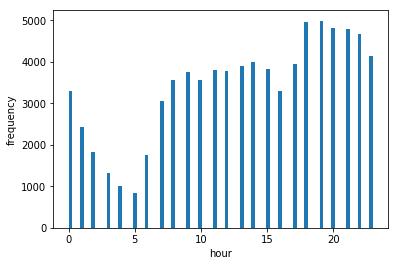

In [132]:
plt.hist(train['hour'],bins=80)
plt.xlabel('hour')
plt.ylabel('frequency')
plt.show()
#much of the travel is between 6 am and 11 pm

In [148]:
train['rush_hour'] = train['hour'].apply(lambda x: 1 if (x > 6 & x < 22) else 0)

In [ ]:
#train['no_rush_hour'] = train['hour'].apply(lambda x: 1 if (x < 6 | x > 22) else 0)

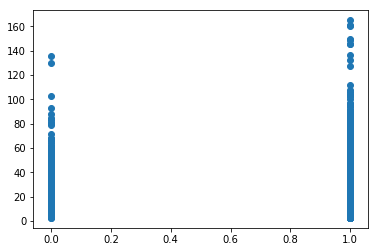

In [149]:
x = train['rush_hour']
y = train['fare_amount']
plt.scatter(x,y)
plt.show()

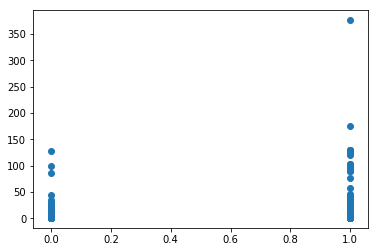

In [150]:
x = train['rush_hour']
y = train['distance']
plt.scatter(x,y)
plt.show()

In [ ]:
#CHarges are more in rush hour traffic

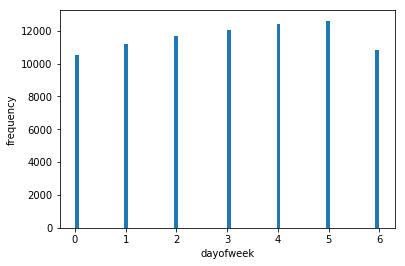

In [137]:
plt.hist(train['dayofweek'],bins=80)
plt.xlabel('dayofweek')
plt.ylabel('frequency')
plt.show()

In [152]:
train['weekend'] = train['dayofweek'].apply(lambda x: 1 if (x == 0 | x == 1) else 0)

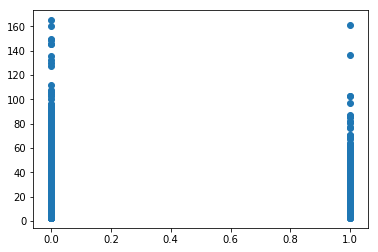

In [153]:
x = train['weekend']
y = train['fare_amount']
plt.scatter(x,y)
plt.show()

In [135]:
print(train[(train['fare_amount'] > 100) & (train['distance'] < 5)] )

                                 key  fare_amount  pickup_longitude  \
14142    2014-12-12 10:13:00.0000003        108.0          -74.0136   
43956    2014-11-01 03:35:37.0000002        165.0          -73.9318   
46198  2013-05-13 11:18:00.000000139        160.0          -73.6445   
56316  2012-10-27 19:45:00.000000108        149.0          -73.7840   
97183    2011-04-19 06:08:34.0000001        103.0          -74.0405   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
14142          40.7059           -74.0007           40.7390                1   
43956          40.7542           -73.9198           40.7977                1   
46198          41.0091           -73.6412           41.0212                1   
56316          40.6464           -73.7922           40.6597                1   
97183          40.7367           -74.0023           40.7292                1   

       distance  year  day  month  weekday  hour  dayofweek  
14142  3.826206  2014   12    

In [136]:
#Check dropoff and pickup of important locations like airport
#train['jfk_drop'] = train[train['dropoff_latitude'] == 40.64 & train['dropoff_longitude'] == -73.78]
#print(train[train['fare_amount'] == 45])
#print(train[(train['dropoff_latitude'] == 40.6413) | (train['dropoff_longitude'] == -73.7781)])

                               key  fare_amount  pickup_longitude  \
74634  2012-06-17 00:54:23.0000001        47.30          -73.9778   
77822  2013-04-04 10:36:39.0000004        57.33          -73.9882   
97972  2014-08-10 14:02:00.0000008        57.33          -73.9740   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
74634          40.7547           -73.9582           40.6413                4   
77822          40.7483           -73.7781           40.6449                1   
97972          40.7618           -73.7781           40.6449                5   

        distance  year  day  month  weekday  hour  dayofweek  
74634  12.706876  2012   17      6        6     0          6  
77822  21.101022  2013    4      4        3    10          3  
97972  21.001934  2014   10      8        6    14          6  


In [156]:
def is_airport_trip(latitude,longitude,airport):
    if (airport == 'JFK'):
        if(40.619 <= latitude <= 40.665 and -73.835 <= longitude <= -73.740):
            return 1
        else:
            return 0
    if(airport == 'LaGuardia'):
        if(40.766 <= latitude <= 40.786 and -73.899 <= longitude <= -73.855):
            return 1
        else:
            return 0
    if (airport == 'EWR'):
        if(40.670 <= latitude <= 40.709 and -74.193 <= longitude <= -74.149):
            return 1
        else:
            return 0


        

In [158]:
train['is_pickup_jfk'] = train.apply(lambda x: is_airport_trip(latitude = x['pickup_latitude'],
                                                                  longitude = x['pickup_longitude'],
                                                                  airport='JFK'),axis=1)

train['is_dropoff_jfk'] = train.apply(lambda x: is_airport_trip(latitude = x['dropoff_latitude'],
                                                                  longitude = x['dropoff_longitude'],
                                                                  airport='JFK'),axis=1)

train['is_pickup_EWR'] = train.apply(lambda x: is_airport_trip(latitude = x['pickup_latitude'],
                                                                  longitude = x['pickup_longitude'],
                                                                  airport='EWR'),axis=1)

train['is_dropoff_EWR'] = train.apply(lambda x: is_airport_trip(latitude = x['dropoff_latitude'],
                                                                  longitude = x['dropoff_longitude'],
                                                                  airport='EWR'),axis=1)

train['is_pickup_LaGuardia'] = train.apply(lambda x: is_airport_trip(latitude = x['pickup_latitude'],
                                                                  longitude = x['pickup_longitude'],
                                                                  airport='LaGuardia'),axis=1)
train['is_dropoff_LaGuardia'] = train.apply(lambda x: is_airport_trip(latitude = x['dropoff_latitude'],
                                                                  longitude = x['dropoff_longitude'],
                                                                  airport='LaGuardia'),axis=1)

In [160]:
from sklearn.model_selection import train_test_split
train.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,day,...,hour,dayofweek,rush_hour,weekend,is_pickup_jfk,is_dropoff_jfk,is_pickup_EWR,is_dropoff_EWR,is_pickup_LaGuardia,is_dropoff_LaGuardia
0,2009-06-15 17:26:21.0000001,4.5,-73.8443,40.7213,-73.8416,40.7123,1,1.030117,2009,15,...,17,0,1,0,0,0,0,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,-74.0160,40.7113,-73.9793,40.7820,1,8.444828,2010,5,...,16,1,1,1,0,0,0,0,0,0
2,2011-08-18 00:35:00.00000049,5.7,-73.9827,40.7613,-73.9912,40.7506,2,1.388653,2011,18,...,0,3,0,0,0,0,0,0,0,0
3,2012-04-21 04:30:42.0000001,7.7,-73.9871,40.7331,-73.9916,40.7581,1,2.797513,2012,21,...,4,5,0,0,0,0,0,0,0,0
4,2010-03-09 07:51:00.000000135,5.3,-73.9681,40.7680,-73.9567,40.7838,1,1.997902,2010,9,...,7,1,1,1,0,0,0,0,0,0


In [163]:
cols = ['passenger_count','distance','year','day','hour','dayofweek','rush_hour','weekend','is_pickup_jfk','is_dropoff_jfk',
        'is_pickup_EWR','is_dropoff_EWR','is_pickup_LaGuardia','is_dropoff_LaGuardia']

In [167]:
X = train[cols]
y = train['fare_amount']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=0)

In [169]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [170]:
from xgboost import XGBRegressor
clf = XGBRegressor(num_estimators=500,max_depth=5,max_features='sqrt',learning_rate=0.1,min_samples_split=500,min_samples_leaf=100)
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print('RMSE: % .2f' % rmse)

RMSE:  3.83
